In [5]:
import tensorflow as tf
import omegaconf
from model import UCCDRNModel
import numpy as np
import os

In [7]:
output_path = os.path.join("outputs/2024-03-25/06-06-14")
model_name = "model_weights.h5"
cfg = omegaconf.OmegaConf.load(os.path.join(output_path, ".hydra\\config.yaml"))

model = UCCDRNModel(cfg)
model.build(input_shape=())
model.load_weights(filepath=os.path.join(output_path, model_name))

ucc classifier initialize 


In [8]:
print(model.summary())

Model: "uccdrn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 10)                375370    
                                                                 
 decoder (Sequential)        (None, 28, 28, 1)         220001    
                                                                 
 drn (Sequential)            (None, 11)                19        
                                                                 
 ucc_classifier (Sequential)  (None, 4)                48        
                                                                 
Total params: 595,438
Trainable params: 595,438
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
splitted_dataset = np.load("../data/mnist/splitted_mnist_dataset.npz")
x_test = splitted_dataset['x_test']
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],x_test.shape[2],1))
x_test = (x_test - np.mean(x_test, axis=(0,1,2)))/ np.std(x_test, axis=(0,1,2))
y_test = splitted_dataset['y_test']

In [29]:
sample_list = []
for i in range(0,10):
    indices = np.where(y_test==i)
    sample = x_test[indices[0]]
    sample_list.append(sample)

In [35]:
def kde(data, sigma=0.1, num_nodes=11,  num_features=None):
    batch_size, num_features = data.shape
    # our input data shape is batchsize x bins
    # we want each linspace to represent a distribution for each feature of each instance. Expected shape = [batch_size, num_nodes]
    k_sample_points = tf.constant(
        np.tile(np.linspace(0, 1, num=num_nodes), [batch_size, 1]).astype(np.float32))
    k_alpha = tf.constant(
        np.array(1/np.sqrt(2*np.pi*np.square(sigma))).astype(np.float32))
    k_beta = tf.constant(
        np.array(-1/(2*np.square(sigma))).astype(np.float32))
    out = []
    # for concatenating across each feature point
    for i in range(num_features):
        # For each feature point
        # Reshape for broadcasting
        
        temp = tf.reshape(
            data[:, i], (batch_size, 1))
        # get x-x_0 values into a grid
        k_diff = k_sample_points - tf.tile(temp, [1, num_nodes])
        diff_sq = tf.square(k_diff)
        k_result = k_alpha * tf.exp(k_beta*diff_sq)
        # add all the feature values across instances. Expected shape = [batch_size, num_nodes]
        k_out_unnormalized = tf.reduce_sum(k_result, axis=0)
        k_norm_coeff = tf.reshape(tf.reduce_sum(
            k_out_unnormalized, axis=0), (-1, 1))
        k_out = k_out_unnormalized / k_norm_coeff
        out.append(tf.reshape(k_out, [1, num_nodes]))
    # Expected output shape =[batch_size,num_features, num_nodes]
    concat_out = tf.concat(out, axis=0)
    return concat_out

In [69]:
print(drn_out_list.shape)
print(distribution_list.shape)

(10, 11)
(10, 110)


In [71]:
distribution_list = []
drn_out_list = []
for s in sample_list:
    feature = model.encoder(s)
    distribution = kde(feature, num_nodes=cfg.args.num_bins, sigma=0.1)
    drn_out = model.drn(tf.expand_dims(distribution, axis=0))
    print(drn_out.shape)
    drn_out_list.append((drn_out))
    distribution_list.append(distribution)
distribution_list = np.concatenate(distribution_list, axis=1)
drn_out_list = np.concatenate(drn_out_list,axis=0)

(1, 11)
(1, 11)
(1, 11)
(1, 11)
(1, 11)
(1, 11)
(1, 11)
(1, 11)
(1, 11)
(1, 11)


In [72]:
for i in drn_out_list:
    print(i)

[0.18657672 0.16092992 0.1373636  0.11602779 0.09698575 0.0802249
 0.06566986 0.05319596 0.04264287 0.03382749 0.02655514]
[0.18657653 0.1609298  0.13736354 0.11602777 0.09698576 0.08022495
 0.06566992 0.05319599 0.04264292 0.03382755 0.02655519]
[0.18657708 0.16093014 0.13736373 0.11602781 0.0969857  0.08022482
 0.06566975 0.05319582 0.04264274 0.03382737 0.02655503]
[0.18657225 0.16092725 0.13736236 0.11602759 0.09698628 0.08022594
 0.0656712  0.05319741 0.04264435 0.03382893 0.02655646]
[0.1865717  0.16092691 0.1373622  0.11602755 0.09698635 0.08022606
 0.06567135 0.05319759 0.04264454 0.0338291  0.02655661]
[0.1865722  0.16092719 0.13736235 0.11602757 0.09698629 0.08022597
 0.06567123 0.05319744 0.04264439 0.03382896 0.02655648]
[0.1865798  0.16093175 0.13736449 0.11602793 0.09698538 0.08022419
 0.06566895 0.05319494 0.04264183 0.0338265  0.02655423]
[0.1865693  0.1609255  0.13736153 0.11602744 0.09698665 0.08022662
 0.06567208 0.05319838 0.04264535 0.03382988 0.02655733]
[0.186573

(10, 110)


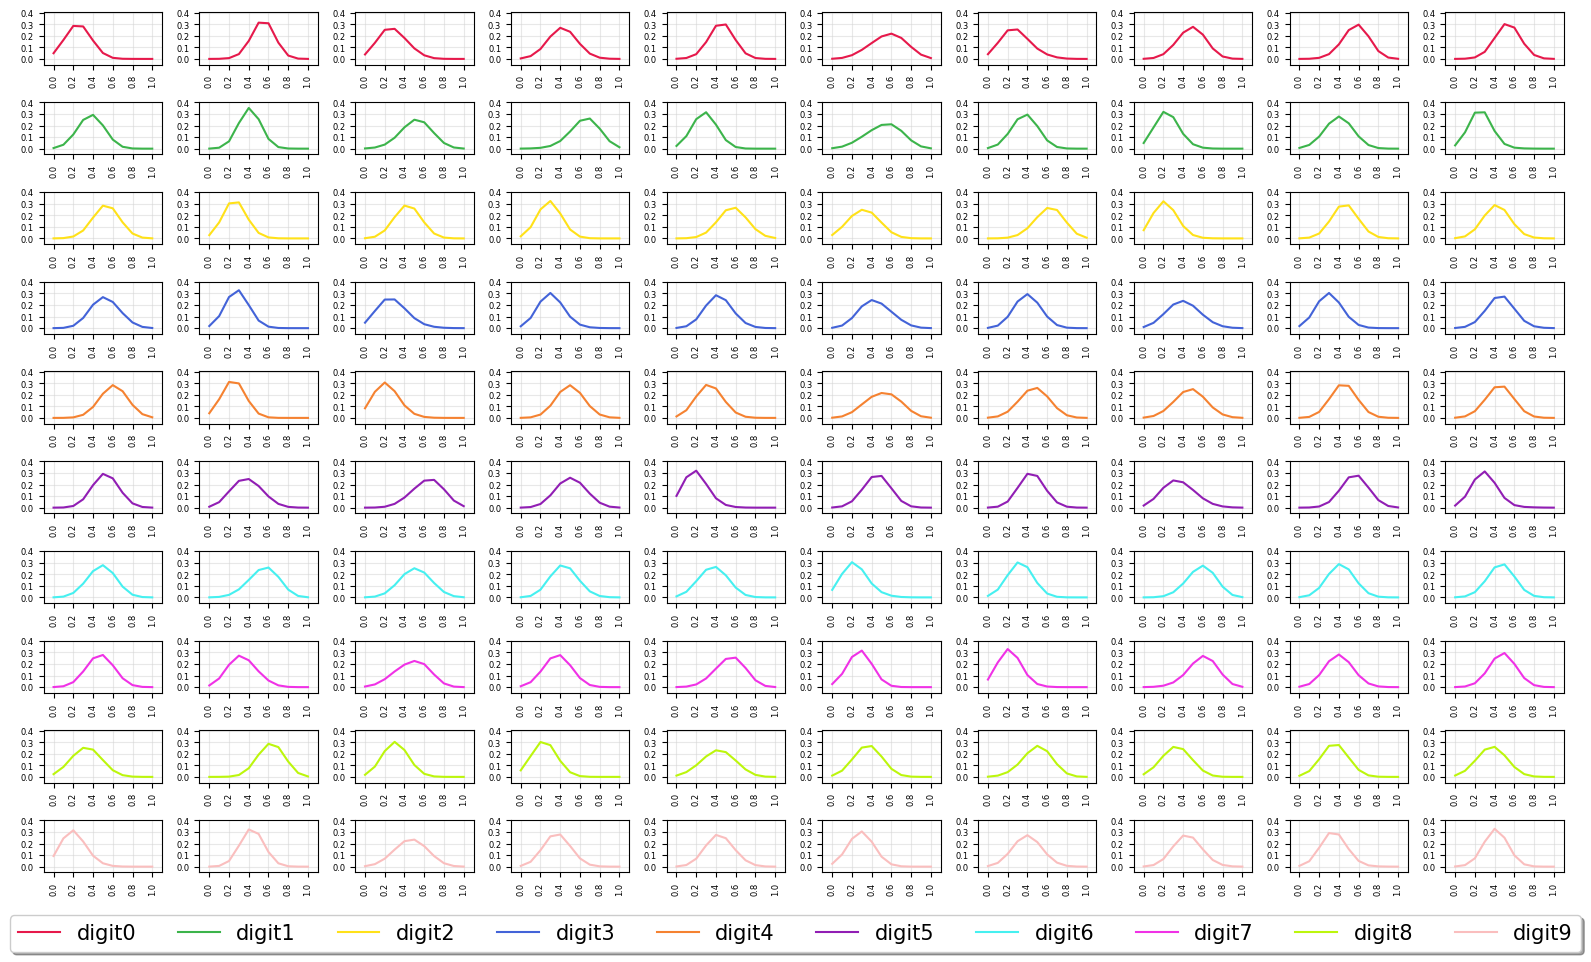

In [68]:
from visualize import visualize_distributions

print(distribution_list.shape)
classes = ["digit" + str(i) for i in range(10)]
visualize_distributions(distribution_list, classes=classes, num_bins=11)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

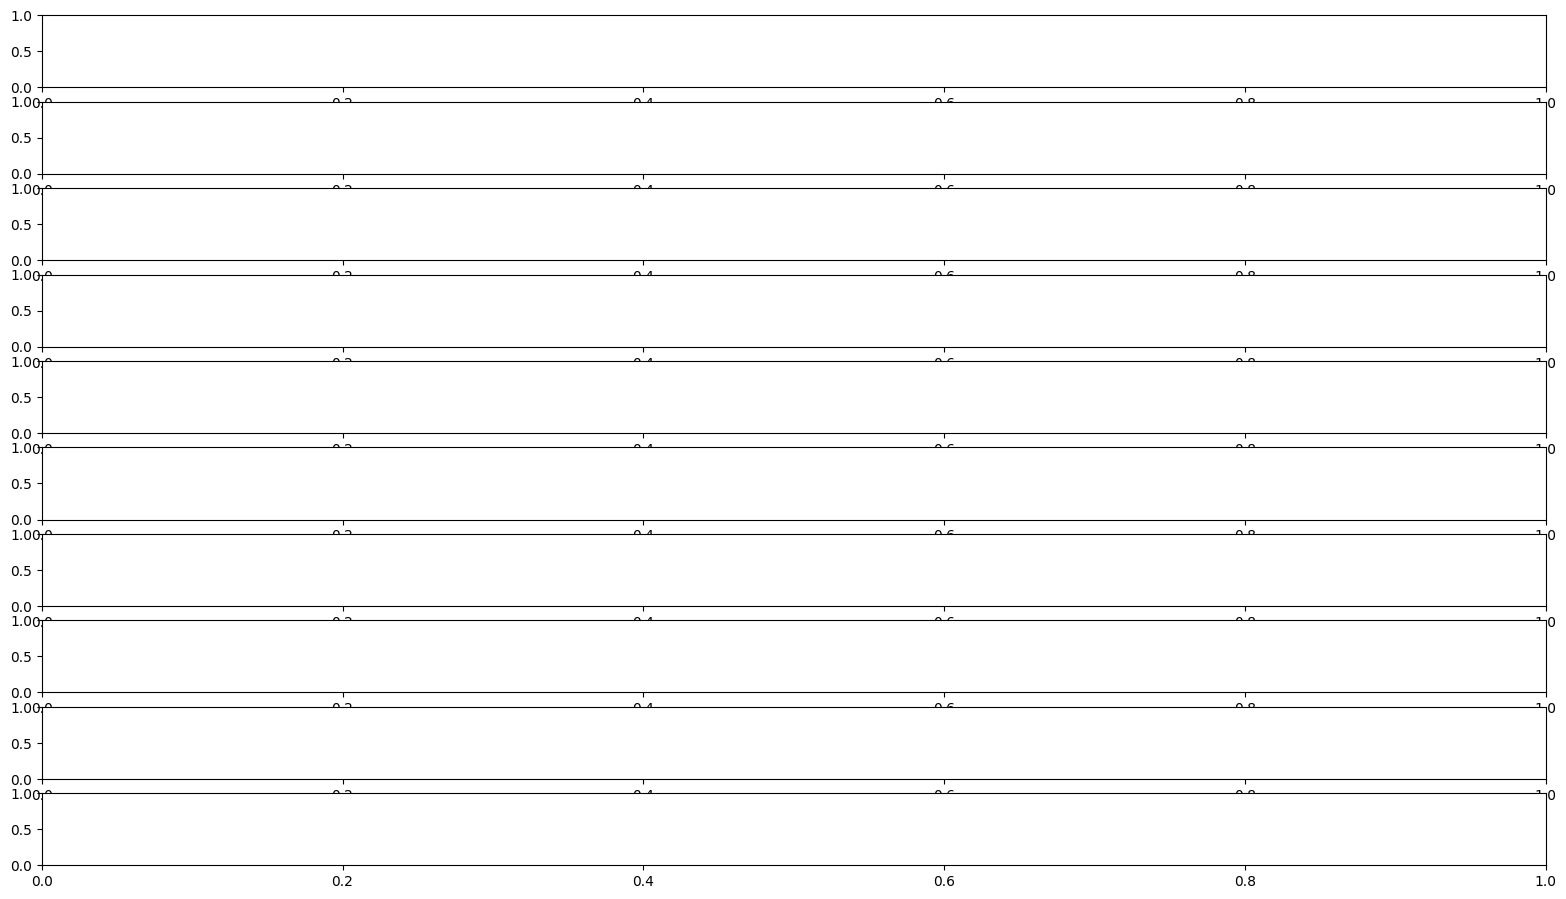

In [70]:
visualize_distributions(drn_out_list, classes=classes, num_bins=11)